In [1]:
from os import path

import random
import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

import matplotlib.pyplot as plt

import dataloaders
import networks.utils as utils
import networks.dcgan as dcgan

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda' #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREATS = torch.get_num_threads()
    print("Number of Threats: ", NUM_THREATS)
else:
    NUM_THREATS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threats:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data","tmdb-64")
TABLE_PATH = path.join("data","tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3 # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
PADDING_MODE = "reflect"
COLORMODE="RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 21
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs","dcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 10
SAVE_FAKES_EVERY_N_EPOCHS = 5

### Load dataset

In [5]:
# Poster subset:
GENRE=None
GENRE_LOGIC='and'
OG_LANG=None
YEAR=None
RUNTIME=(40, np.inf)
MAX_NUM=50000
SORT=None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                    img_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                    colormode=COLORMODE,
                                    img_in_ram=False,
                                    genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR, runtime=RUNTIME,
                                    max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREATS, pin_memory=PIN_MEMORY)

Sample dataset:

The dataset has 50000 entries.


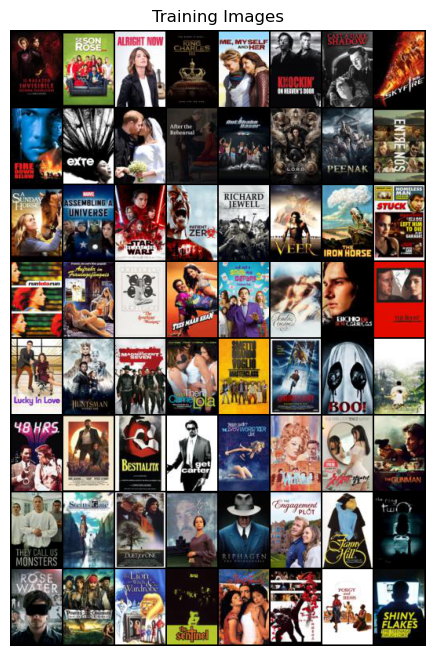

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [7]:
generator, discriminator = dcgan.create_gan(img_size=IMAGE_SIZE, img_ratio=IMAGE_SIZE_RATIO , num_img_channels=NUM_IMG_CHANNELS, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G, base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE, device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, IMAGE_SIZE_RATIO, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, IMAGE_SIZE*IMAGE_SIZE_RATIO//2, IMAGE_SIZE))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 6, 4]         819,200
       BatchNorm2d-2            [-1, 512, 6, 4]           1,024
              ReLU-3            [-1, 512, 6, 4]               0
   ConvTranspose2d-4           [-1, 256, 12, 8]       2,097,152
       BatchNorm2d-5           [-1, 256, 12, 8]             512
              ReLU-6           [-1, 256, 12, 8]               0
   ConvTranspose2d-7          [-1, 128, 24, 16]         524,288
       BatchNorm2d-8          [-1, 128, 24, 16]             256
              ReLU-9          [-1, 128, 24, 16]               0
  ConvTranspose2d-10           [-1, 64, 48, 32]         131,072
      BatchNorm2d-11           [-1, 64, 48, 32]             128
             ReLU-12           [-1, 64, 48, 32]               0
  ConvTranspose2d-13            [-1, 3, 96, 64]           3,072
             Tanh-14        

In [8]:
trainer = dcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO, d_params=discriminator.parameters(), g_params=generator.parameters(), learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

[0/20]	Loss_D: 0.3778	Loss_G: 5.0859	D(x): 0.9244	D(G(z)): 0.2233 / 0.0189: 100%|██████████| 782/782 [01:05<00:00, 11.95it/s] 


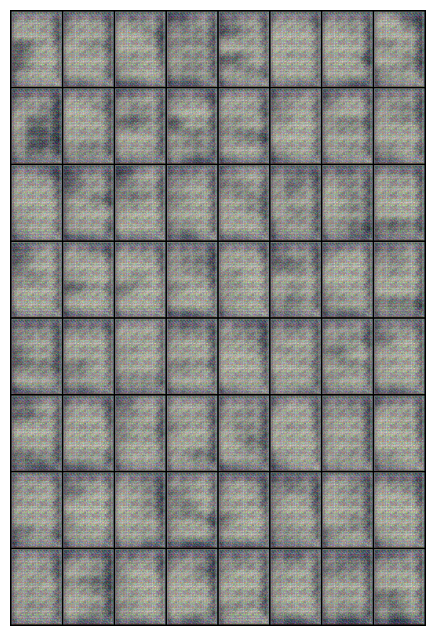

[1/20]	Loss_D: 0.7000	Loss_G: 2.4100	D(x): 0.6927	D(G(z)): 0.1629 / 0.1196: 100%|██████████| 782/782 [01:05<00:00, 11.99it/s]
[2/20]	Loss_D: 0.2389	Loss_G: 5.2330	D(x): 0.9430	D(G(z)): 0.1573 / 0.0085: 100%|██████████| 782/782 [01:04<00:00, 12.07it/s]
[3/20]	Loss_D: 0.1733	Loss_G: 5.5726	D(x): 0.9323	D(G(z)): 0.0859 / 0.0069: 100%|██████████| 782/782 [01:04<00:00, 12.04it/s]
[4/20]	Loss_D: 0.9067	Loss_G: 7.3355	D(x): 0.9115	D(G(z)): 0.4611 / 0.0046: 100%|██████████| 782/782 [01:04<00:00, 12.03it/s]
[5/20]	Loss_D: 0.7872	Loss_G: 5.5967	D(x): 0.7211	D(G(z)): 0.0606 / 0.0205: 100%|██████████| 782/782 [01:04<00:00, 12.09it/s]


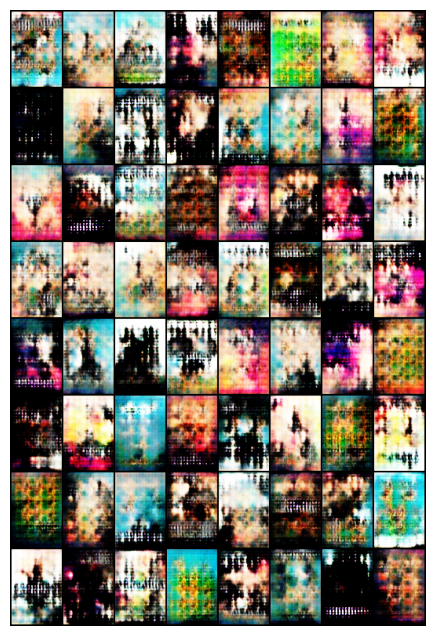

[6/20]	Loss_D: 0.8646	Loss_G: 2.9687	D(x): 0.5510	D(G(z)): 0.0711 / 0.1454: 100%|██████████| 782/782 [01:04<00:00, 12.03it/s]
[7/20]	Loss_D: 0.4013	Loss_G: 3.6794	D(x): 0.8438	D(G(z)): 0.1668 / 0.0346: 100%|██████████| 782/782 [01:04<00:00, 12.21it/s]
[8/20]	Loss_D: 0.3346	Loss_G: 4.7942	D(x): 0.8864	D(G(z)): 0.1663 / 0.0129: 100%|██████████| 782/782 [01:04<00:00, 12.20it/s]
[9/20]	Loss_D: 0.3045	Loss_G: 4.3689	D(x): 0.8788	D(G(z)): 0.1370 / 0.0209: 100%|██████████| 782/782 [01:11<00:00, 11.00it/s]
[10/20]	Loss_D: 0.5961	Loss_G: 1.7110	D(x): 0.7314	D(G(z)): 0.1605 / 0.2244: 100%|██████████| 782/782 [01:05<00:00, 11.96it/s]


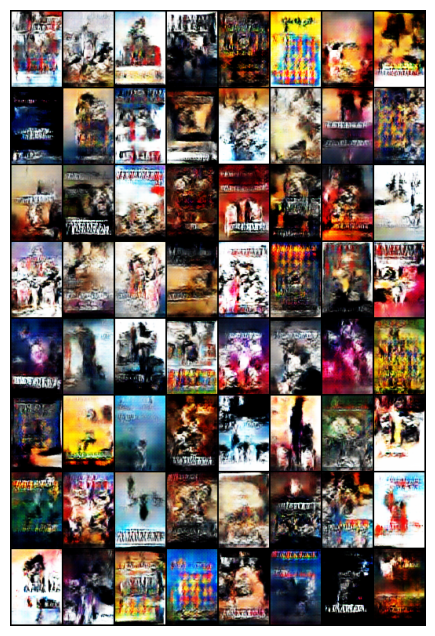

[11/20]	Loss_D: 0.7919	Loss_G: 9.5634	D(x): 0.9145	D(G(z)): 0.3725 / 0.0026: 100%|██████████| 782/782 [01:04<00:00, 12.14it/s]
[12/20]	Loss_D: 0.3281	Loss_G: 2.7663	D(x): 0.7752	D(G(z)): 0.0386 / 0.0942: 100%|██████████| 782/782 [01:08<00:00, 11.44it/s]
[13/20]	Loss_D: 0.5442	Loss_G: 2.0064	D(x): 0.6920	D(G(z)): 0.0872 / 0.1533: 100%|██████████| 782/782 [01:05<00:00, 11.98it/s]
[14/20]	Loss_D: 0.0961	Loss_G: 5.2009	D(x): 0.9442	D(G(z)): 0.0345 / 0.0126: 100%|██████████| 782/782 [01:05<00:00, 12.03it/s] 
[15/20]	Loss_D: 0.6137	Loss_G: 7.7114	D(x): 0.9341	D(G(z)): 0.3425 / 0.0019: 100%|██████████| 782/782 [01:05<00:00, 11.95it/s] 


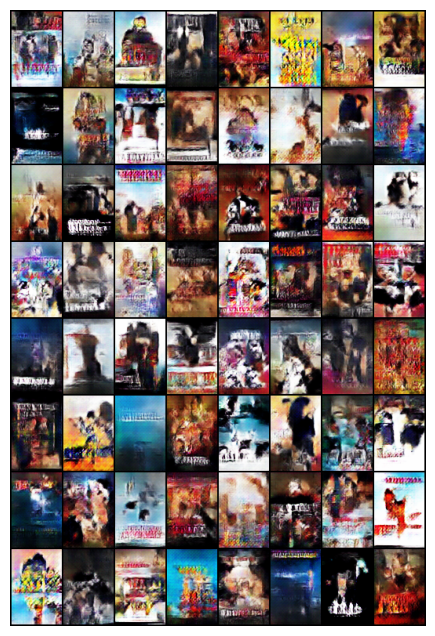

[16/20]	Loss_D: 0.7657	Loss_G: 6.5975	D(x): 0.7709	D(G(z)): 0.2800 / 0.0101: 100%|██████████| 782/782 [01:07<00:00, 11.63it/s] 
[17/20]	Loss_D: 0.2017	Loss_G: 5.3300	D(x): 0.8869	D(G(z)): 0.0607 / 0.0108: 100%|██████████| 782/782 [01:05<00:00, 12.03it/s] 
[18/20]	Loss_D: 0.1953	Loss_G: 5.0199	D(x): 0.9004	D(G(z)): 0.0462 / 0.0129: 100%|██████████| 782/782 [01:04<00:00, 12.08it/s] 
[19/20]	Loss_D: 0.1667	Loss_G: 4.9368	D(x): 0.8717	D(G(z)): 0.0170 / 0.0147: 100%|██████████| 782/782 [01:05<00:00, 12.02it/s] 
[20/20]	Loss_D: 0.3934	Loss_G: 7.7828	D(x): 0.9669	D(G(z)): 0.2326 / 0.0014: 100%|██████████| 782/782 [01:05<00:00, 12.01it/s] 


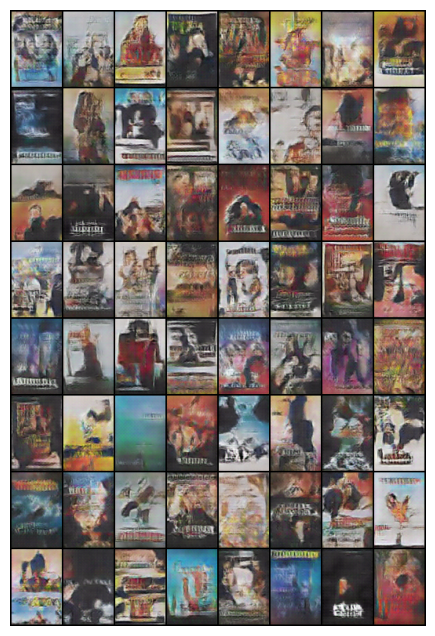

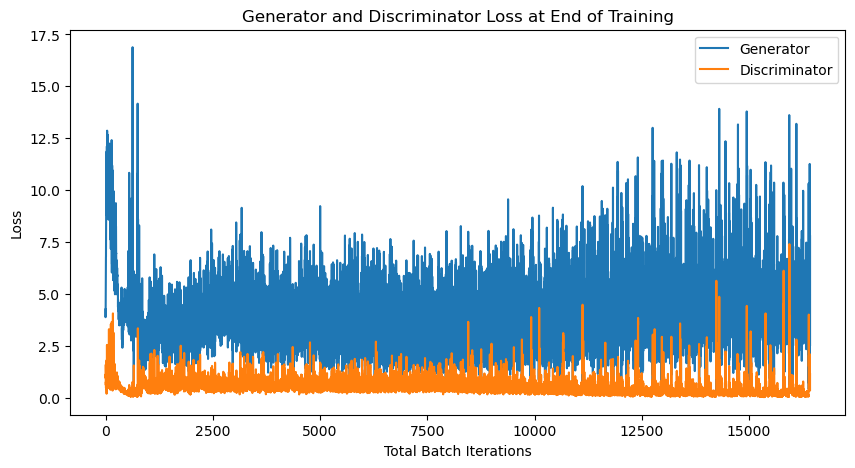

In [9]:
SHOW_GRAPHS = True

trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device, fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS, show_graphs=SHOW_GRAPHS)

### Show results

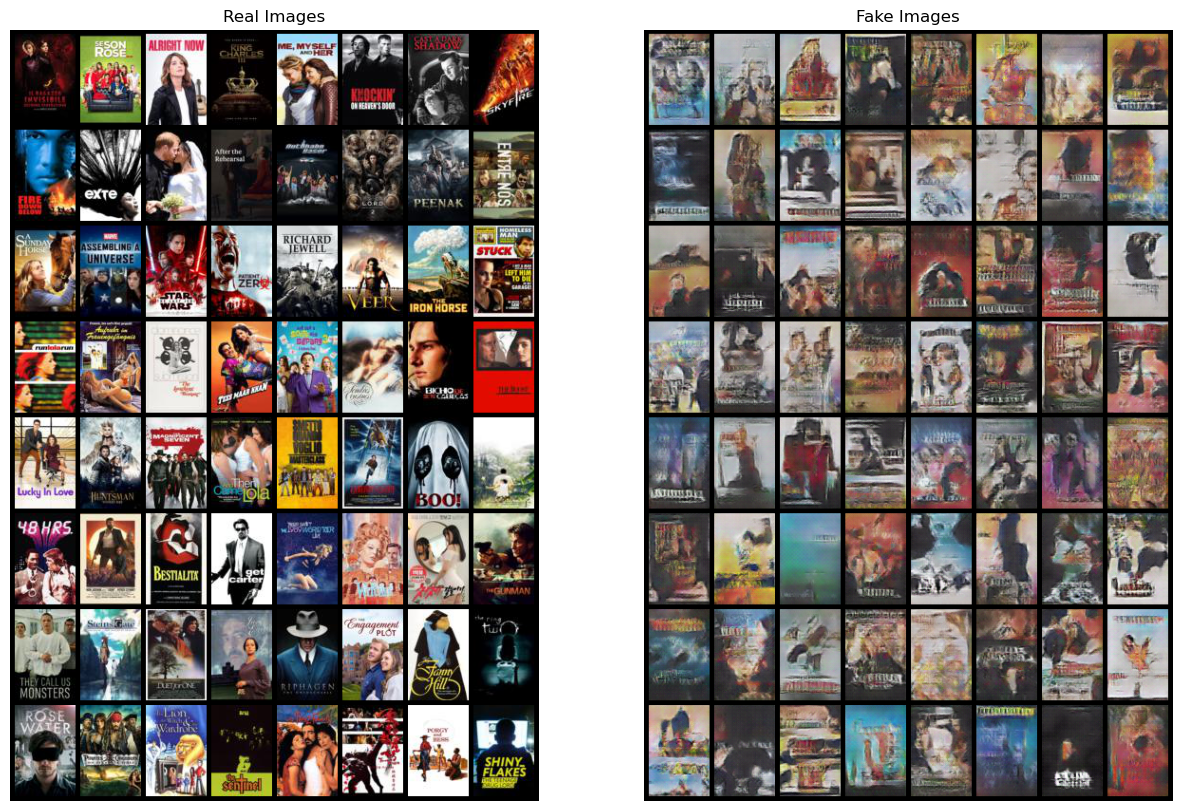

In [10]:
with torch.no_grad():
    sample_fakes = generator(trainer.noise_samples).detach().cpu()
sample_fakes = vutils.make_grid(sample_fakes, padding=5, normalize=True)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_reals[0].to(device)[:NUM_SAMPLES], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(sample_fakes, (1, 2, 0)))
plt.show()

fig.savefig(path.join(trainer.last_out_dir, "real_vs_fake.png"))